In [48]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
import random
import pymulticonsensus
from utils import download_datasets, load_data, misclassification, model_type, get_soft_assignment
from time import time

In [49]:
# Load data from all scenes in the dataset
dataset = "adelaideF"
url_base = 'https://n.ethz.ch/~dbarath/data/'

# Downloading the datasets used for the evaluation if needed
download_datasets(url_base, [dataset])

# Loading the scenes from the downloaded dataset
data = load_data(dataset)


In [50]:
#Now, some visualization from OpenCV tutorial
#https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html
#We will draw correspondences found and the geometric transformation between the images.
from copy import deepcopy
def decolorize(img):
    return  cv2.cvtColor(cv2.cvtColor(img,cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB)

def draw_matches(kps1, kps2, tentatives, img1, img2, mask, color):    
    matchesMask = mask.ravel().tolist()
    
    # Blue is estimated, green is ground truth homography
    draw_params = dict(matchColor = color, # draw matches in yellow color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
    img_out = cv2.drawMatches(decolorize(img1),kps1,decolorize(img2),kps2,tentatives,None,**draw_params)
    plt.figure(figsize = (12,8))
    plt.imshow(cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB))
    plt.show() 
    return 

def draw_labeling(img1, img2, labeling, correspondences):
    img1_cpy = img1.copy()
    img2_cpy = img2.copy()
    
    for label in range(max(labeling)):
        mask = labeling == label
        color = random_color(label)

        for i in range(len(labeling)):
            if mask[i]:
                cv2.circle(img1_cpy, (round(correspondences[i][0]), round(correspondences[i][1])), 4, color, -1)
                cv2.circle(img2_cpy, (round(correspondences[i][2]), round(correspondences[i][3])), 4, color, -1)

    # Plot the two images side by side using matplotlib.pyplot
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(12, 8)
    ax1.imshow(img1_cpy)
    ax1.set_title('Hard assignment by PEARL')
    ax2.imshow(img2_cpy)
    plt.show()

def random_color(label = None):
    if label is not None:
        if label == 0:
            return (255, 0, 0)
        elif label == 1:
            return (0, 255, 0)
        elif label == 2:
            return (0, 0, 255)
    return (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

def get_soft_assignment(correspondences, homographies, inlier_threshold):
    model_number = int(homographies.shape[0] / 3)
    point_number = correspondences.shape[0]
    assignments = np.zeros((point_number, model_number))

    for model_idx in range(int(model_number)):
        # Get the current model parameters
        homography = homographies[model_idx * 3 : (model_idx + 1) * 3, :]
        
        # Iterate through the points and get the inliers of the current homography 
        for point_idx in range(point_number):
            # Project the point in the source image by the estimated homography
            pt1 = np.array([correspondences[point_idx, 0], correspondences[point_idx, 1], 1])
            pt2 = np.array([correspondences[point_idx, 2], correspondences[point_idx, 3], 1])
            pt1_transformed = homography @ pt1
            pt1_transformed /= pt1_transformed[2]
            
            # Calculate the point-to-model residual
            residual = np.linalg.norm(pt1_transformed - pt2)
            
            # Store the inlier probabilities
            if residual < inlier_threshold:
                probability = math.exp(-1.0 / 2.0 * (residual / inlier_threshold)**2)
                assignments[point_idx, model_idx] = probability
    return assignments

def draw_soft_assignment(img1, img2, assignments, correspondences):
    point_number = assignments.shape[0]
    model_number = assignments.shape[1]
    shared_color = (255, 0, 0)
    colors = []
    for model_idx in range(model_number):
        colors.append(random_color())
        
    img1_cpy = img1.copy()
    img2_cpy = img2.copy()

    for point_idx in range(point_number):
        model_indices = assignments[point_idx, :] > 0

        if np.sum(model_indices) > 1:
            cv2.circle(img1_cpy, (round(correspondences[point_idx][0]), round(correspondences[point_idx][1])), 4, shared_color, -1)
            cv2.circle(img2_cpy, (round(correspondences[point_idx][2]), round(correspondences[point_idx][3])), 4, shared_color, -1)
        elif np.sum(model_indices) == 1:
            idx = np.where(model_indices)[0][0]
            cv2.circle(img1_cpy, (round(correspondences[point_idx][0]), round(correspondences[point_idx][1])), 4, colors[idx], -1)
            cv2.circle(img2_cpy, (round(correspondences[point_idx][2]), round(correspondences[point_idx][3])), 4, colors[idx], -1)

    # Plot the two images side by side using matplotlib.pyplot
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
    ax1.imshow(img1_cpy)
    ax1.set_title('Soft assignment ')
    ax2.imshow(img2_cpy)
    ax2.set_title('(red points have multiple models)')
    plt.show()

In [51]:
def process_scene(path, scene, correspondences, ref_labeling, inlier_threshold, visualize = True):
    # Load the images
    img1 = cv2.cvtColor(cv2.imread(f"{path}/{scene}/{scene}1.png"), cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(cv2.imread(f"{path}/{scene}/{scene}2.png"), cv2.COLOR_BGR2RGB)
    
    start = time()
    motions = pymulticonsensus.findTwoViewMotions(
        np.ascontiguousarray(correspondences), 
        img1.shape[1], img1.shape[0], 
        img2.shape[1], img2.shape[0],
        threshold = inlier_threshold,
        confidence = 0.999,
        neighborhood_ball_radius = 20.0,
        maximum_tanimoto_similarity = 0.85,
        starting_hypothesis_number = 10,
        added_hypothesis_number = 10,
        max_iters = 75,
        minimum_point_number = 20,
        sampler_id = 1) 
    end = time()
    total_time = end - start
    print(f"Run-time = {total_time:.3f} seconds")

    # Get the soft assignment and draw it.
    motions = np.array(motions)
    model_number = int(motions.shape[0] / 3)
    print(f"Model number = {model_number}")

    # Get hard labeling by a energy-based labeling of PEARL
    labeling = pymulticonsensus.getLabeling(
	    motions.reshape(model_number, 9),
	    correspondences,
	    model_type("two_view_motion"),
	    inlier_threshold,
        20.0,
        0.0,
        0.0)
    labeling += 1
    
    misclassification_error = misclassification(labeling, ref_labeling)   
    print(f"Misclassification error = {misclassification_error:.3f}")
 
    # Draw the results
    if visualize:
        soft_assignment = get_soft_assignment(correspondences, motions, inlier_threshold)
        draw_soft_assignment(img1, img2, soft_assignment, correspondences)
        draw_labeling(img1, img2, labeling - 1, correspondences)

    return misclassification_error, total_time

Processing scene 'game'
Run-time = 0.008 seconds
Model number = 1
Misclassification error = 0.052


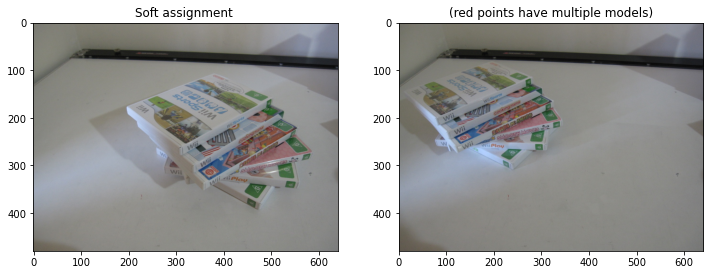

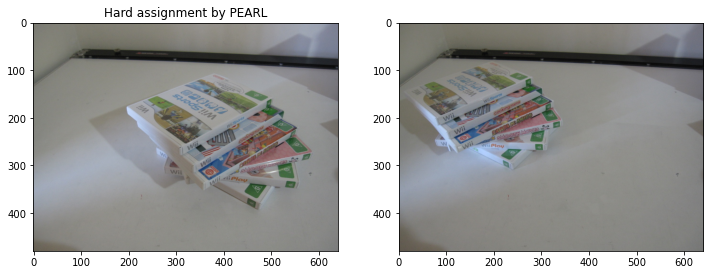

Processing scene 'breadtoycar'
Run-time = 0.013 seconds
Model number = 3
Misclassification error = 0.157


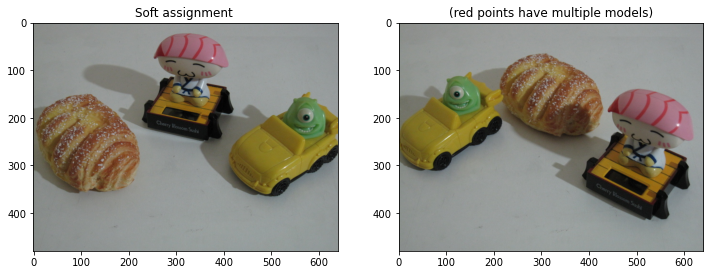

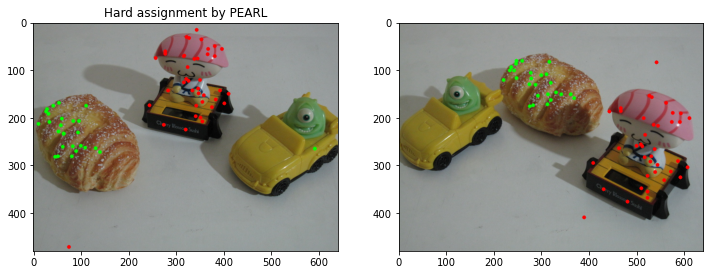

Processing scene 'breadcube'
Run-time = 0.039 seconds
Model number = 2
Misclassification error = 0.058


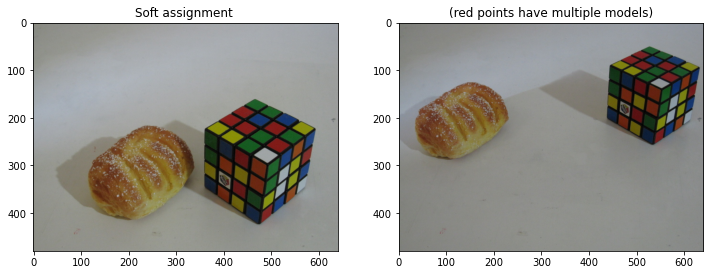

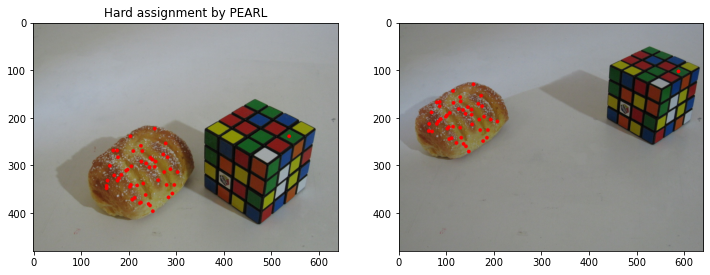

Processing scene 'biscuitbookbox'
Run-time = 0.053 seconds
Model number = 3
Misclassification error = 0.351


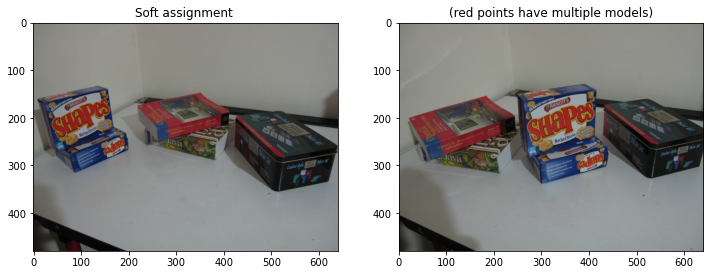

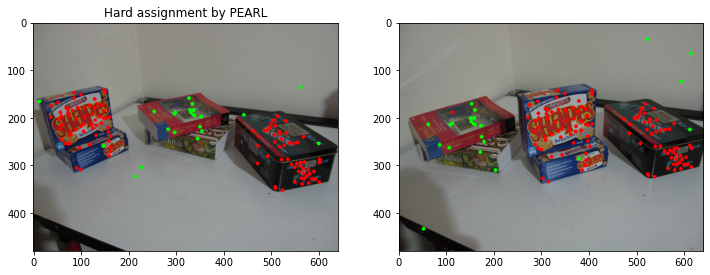

Processing scene 'cubetoy'
Run-time = 0.049 seconds
Model number = 2
Misclassification error = 0.084


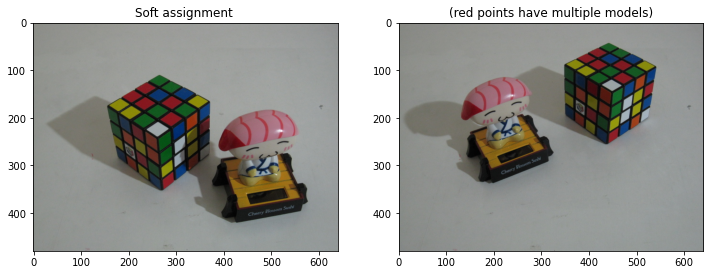

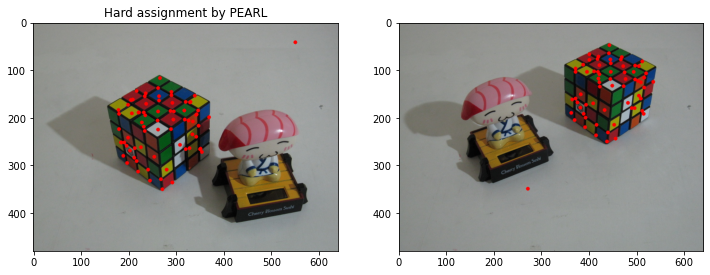

Processing scene 'cubechips'
Run-time = 0.056 seconds
Model number = 2
Misclassification error = 0.081


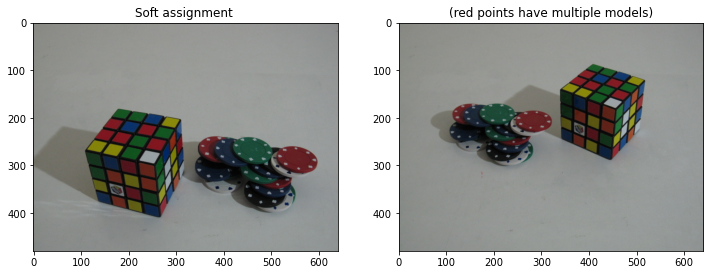

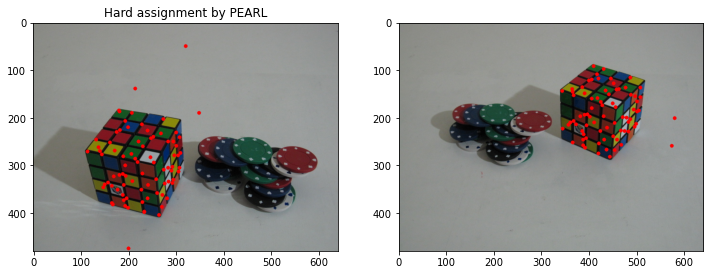

Processing scene 'dinobooks'
Run-time = 0.072 seconds
Model number = 4
Misclassification error = 0.258


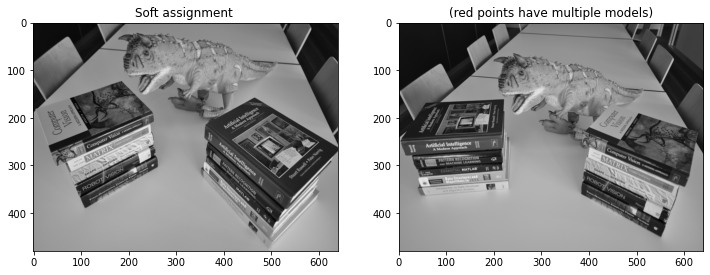

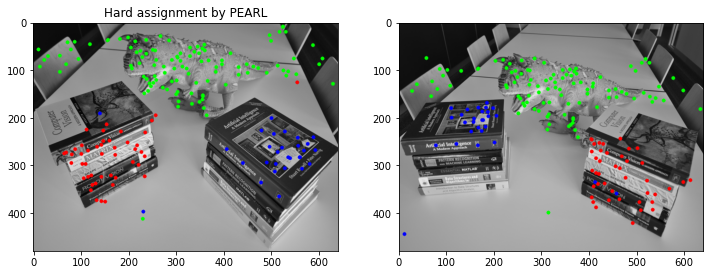

Processing scene 'breadcartoychips'
Run-time = 0.053 seconds
Model number = 4
Misclassification error = 0.152


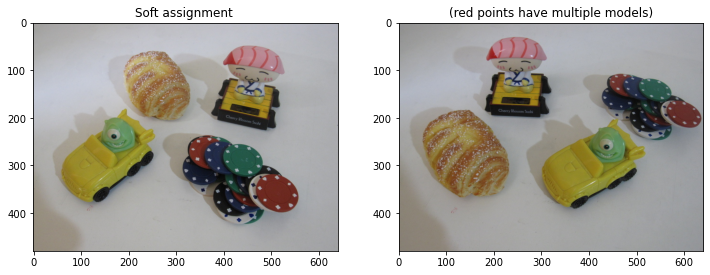

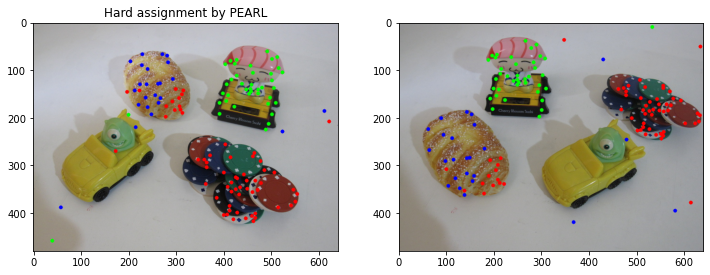

Processing scene 'boardgame'
Run-time = 0.061 seconds
Model number = 2
Misclassification error = 0.168


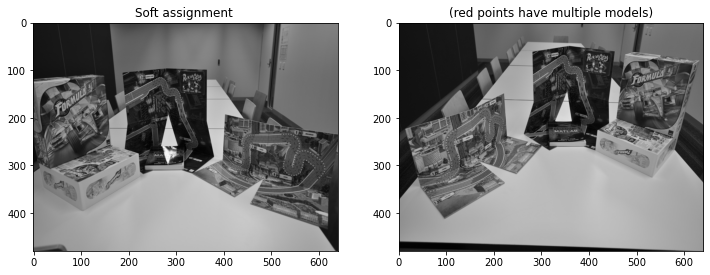

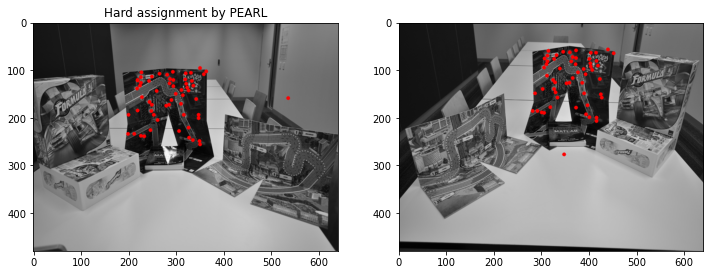

Processing scene 'book'
Run-time = 0.032 seconds
Model number = 1
Misclassification error = 0.000


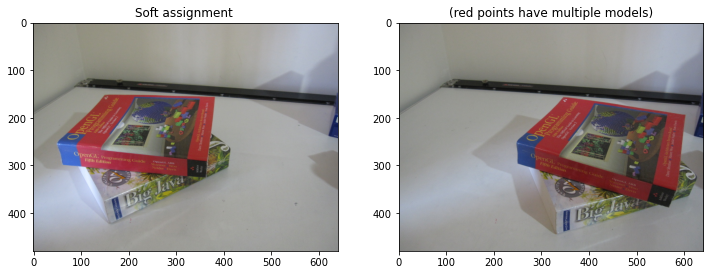

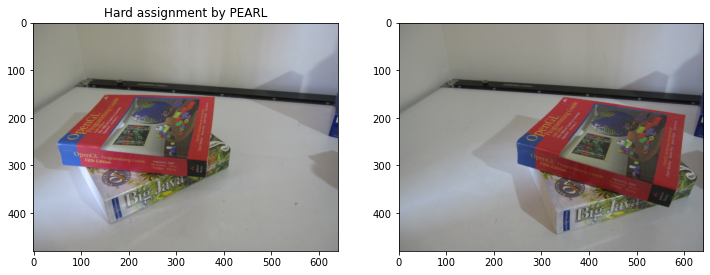

Processing scene 'gamebiscuit'
Run-time = 0.052 seconds
Model number = 2
Misclassification error = 0.064


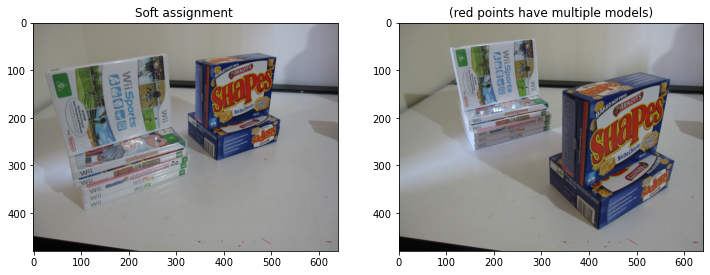

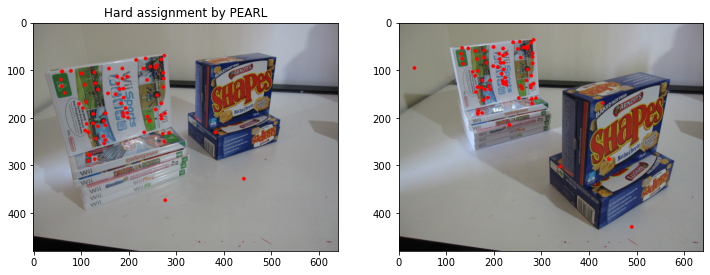

Processing scene 'biscuit'
Run-time = 0.045 seconds
Model number = 1
Misclassification error = 0.012


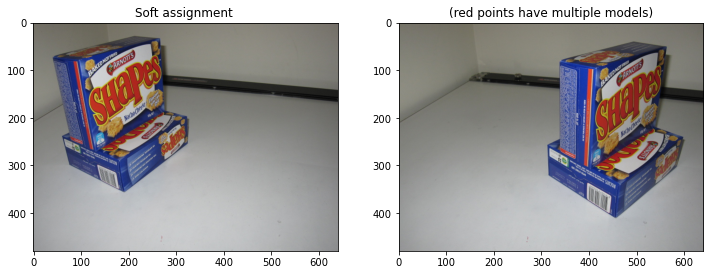

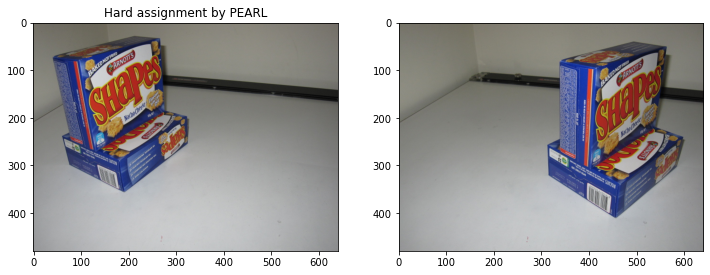

Processing scene 'cubebreadtoychips'
Run-time = 0.001 seconds
Model number = 0


ValueError: Models should be an array with dims [n,m], n>=1.

In [52]:
MEs = []
times = []
for scene in data:
    print(f"Processing scene '{scene}'")
    misclassification_error, processing_time = process_scene(f"{dataset}", scene, data[scene]['corrs'], data[scene]['labels'], 2.5)
    MEs.append(misclassification_error)
    times.append(processing_time)

In [ ]:
print(f"Average ME on the AdelaideH dataset = {np.mean(MEs):.3f}")
print(f"Average run-time on the AdelaideH dataset = {np.mean(times):.3f} seconds")

Average ME on the AdelaideH dataset = 0.084
Average run-time on the AdelaideH dataset = 0.051 seconds
